## Problem description:

Design a model that classifies input queries as linked or unlinked. This model will help us determine if a tangible difference exists between these groups. Use logistic regression and vectorize by sklearn's CountVectorizer. Once designed, train this model on a large data set of query bodies. The model should be tested using cross-validation.

### Import prerequisites:

In [114]:
from functools import reduce
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pysolr
import seaborn as sns

### Load data:

First obtain all the queries from Solr. These should be classified as linked or unlinked based on whether there are entries in the `links_to_solution` field.

In [2]:
def get_documents(solr, query, sort="date desc,id asc", batch_size=100):
    """Retrieve documents from Solr.
    
    :param solr: Instance of the pysolr.Solr class.
    :param query: Solr query.
    :param sort: field and order to sort results by.
    :param batch_size: how many documents to retrieve per batch.
    :type solr: pysolr.Solr
    :type query: str
    :type sort: str
    :type batch_size: int
    :rtype: generator
    
    """
    documents_remaining = True
    cursor = "*"
    while documents_remaining:
        results = solr.search(query, cursorMark=cursor, rows=batch_size, sort=sort)
        for result in results:
            yield result
        documents_remaining = cursor != results.nextCursorMark
        cursor = results.nextCursorMark

#### Set up a function (with defaults) to create a filter for domains.

In [22]:
domains = ['VMware vSphere ESXi 5.5', 'VMware vCenter Server 5.5', 'VMware Update Manager 5.5',
           'VMware vCenter Server Appliance 5.5', 'VMware vSphere Client 5.5']

def create_domain_group_filter(field, domains=domains):
    domain_filters = ' '.join([f'{field}:"{domain}"' for domain in domains])
    return f'+({domain_filters})'

#### Obtain all questions for a specific domain within a year.

In [93]:
namespace, hostkey = 'NEW_PRD', 'vmware-sfkm'
solr = pysolr.Solr(f'http://solrcloud-prd01-useast1a.it9.org:8983/solr/{namespace}-{hostkey}')

domain_filter = create_domain_group_filter('domain', domains=domains)
date_filter = '+(date:[2017-07-01T00:00:00Z TO 2018-07-01T00:00:00Z])'
question_query = f'+(doc_type:question) {domain_filter} {date_filter}'

questions = list(get_documents(solr, question_query))

#### Classify questions as linked (`True`) or unlinked (`False`) and extract bodies and titles:

In [95]:
question_classifications = [True if 'links_to_solution' in question and question['links_to_solution'] else False
                            for question in questions]

question_bodies = [question['body'] for question in questions]

question_titles = [question['title'] if 'title' in question else '' for question in questions]

question_bodies_and_titles = [body + ' \n\n' + title for body, title in zip(question_bodies, question_titles)]

print(f'There are a total of {len(questions)} questions, {sum(question_classifications)} of which have links.')

There are a total of 71329 questions, 3526 of which have links.


#### Balance the classes, so that there are an equal number of linked and unlinked questions

In [104]:
# Separate the classes:

linked_bodies = []
linked_titles = []
linked_bodies_and_titles = []
linked_classifications = []
unlinked_bodies = []
unlinked_titles = []
unlinked_bodies_and_titles = []

for question_ind in range(len(question_classifications)):
    if question_classifications[question_ind]:
        linked_bodies.append(question_bodies[question_ind])
        linked_titles.append(question_titles[question_ind])
        linked_bodies_and_titles.append(question_bodies_and_titles[question_ind])
        linked_classifications.append(question_classifications[question_ind])
    else:
        unlinked_bodies.append(question_bodies[question_ind])
        unlinked_titles.append(question_titles[question_ind])
        unlinked_bodies_and_titles.append(question_bodies_and_titles[question_ind])

# Generate a list of random indices to sample the unlinked questions:
unlinked_indices = np.arange(len(unlinked_bodies))
np.random.shuffle(unlinked_indices)
random_unlinked_indices = unlinked_indices[:len(linked_bodies)]

# Extract random unlinked samples:
random_unlinked_bodies = list(np.array(unlinked_bodies)[random_unlinked_indices])
random_unlinked_titles = list(np.array(unlinked_titles)[random_unlinked_indices])
random_unlinked_bodies_and_titles = list(np.array(unlinked_bodies_and_titles)[random_unlinked_indices])
random_unlinked_classifications = [False for _ in range(len(random_unlinked_bodies_and_titles))]

# Recombine linked and unlinked samples:
combined_question_bodies = linked_bodies + random_unlinked_bodies
combined_question_titles = linked_titles + random_unlinked_titles
combined_question_bodies_and_titles = linked_bodies_and_titles + random_unlinked_bodies_and_titles
combined_question_classifications = linked_classifications + random_unlinked_classifications

# Shuffle the combined sample:
random_all_indices = np.arange(len(combined_question_titles))
np.random.shuffle(random_all_indices)
random_question_bodies = list(np.array(combined_question_bodies)[random_all_indices])
random_question_titles = list(np.array(combined_question_titles)[random_all_indices])
random_question_bodies_and_titles = list(np.array(combined_question_bodies_and_titles)[random_all_indices])
random_question_classifications = list(np.array(combined_question_classifications)[random_all_indices])

#### Vectorize the question bodies and titles:

In [119]:
count_vectorizer_bodies = CountVectorizer(stop_words='english')
count_vectorized_bodies = count_vectorizer_bodies.fit_transform(random_question_bodies)

count_vectorizer_titles = CountVectorizer(stop_words='english')
count_vectorized_titles = count_vectorizer_titles.fit_transform(random_question_titles)

count_vectorizer_bt = CountVectorizer(stop_words='english')
count_vectorized_bodies_and_titles = count_vectorizer_bt.fit_transform(random_question_bodies_and_titles)

tfidf_vectorizer_bodies = TfidfVectorizer(stop_words='english')
tfidf_vectorized_bodies = tfidf_vectorizer_bodies.fit_transform(random_question_bodies)

tfidf_vectorizer_titles = TfidfVectorizer(stop_words='english')
tfidf_vectorized_titles = tfidf_vectorizer_titles.fit_transform(random_question_titles)

tfidf_vectorizer_bt = TfidfVectorizer(stop_words='english')
tfidf_vectorized_bodies_and_titles = tfidf_vectorizer_bt.fit_transform(random_question_bodies_and_titles)

#### Create a helper function to train and test a logistic regression model:

In [46]:
def perform_logistic_regression(input_vectors, input_classifications, test_size, random_state):
    """
    
    :param input_vectors: Output from CountVectorizer, containing vectors for each question.
    :param input_classifications: Boolean values for whether the question was linked to a solution.
    :param test_size: Fraction of sample used in the test group.
    :param random_state: State used in making the train-test split.
    :type input_vector: scipy.sparse.csr.csr_matrix
    :type input_classification: list
    :type test_size: float
    :type random_state: int
    :rtype: list, list, list, float, scipy.sparse.csr.csr_matrix
    
    """
    input_train, input_test, class_train, class_test = train_test_split(input_vectors,
                                                                        input_classifications,
                                                                        test_size=test_size,
                                                                        random_state=random_state)
    print(f'Sample split: {len(class_train)} training data points, {len(class_test)} test data points')
    
    logistic_regression = LogisticRegression()
    logistic_regression.fit(input_train, class_train)
    class_predictions = logistic_regression.predict(input_test)
    test_score = logistic_regression.score(input_test, class_test)
    confusion_matrix = metrics.confusion_matrix(class_test, class_predictions)
    print(f'Fraction correctly predicted: {test_score}\n')

    return input_test, class_test, class_predictions, test_score, confusion_matrix

#### Create a function that takes a list of confusion matrices and test scores and plots out the averages:

In [117]:
def plot_average_confusion_matrix(scores, confusion_matrices, data_type):
    """
    
    :param scores: A list of the scores resulting from each model, where:
        `score = number_of_correct_predictions / total_predictions`.
    :param confusion_matrices: Confusion matrices from individual models, each
        column is a predicted label, and each row is an actual label. The
        number in each element is the total samples with that combination of
        predicted and actual label.
    :param data_type: A descriptive label that will go in the title of the
        produced plot.
    :type scores: list
    :type confusion_matrices: list
    :type data_type: str

    """
    average_score = np.mean(scores)
    plot_title = f'{data_type}\naverage score: {round(average_score, 3)}'

    sum_confusion = reduce(np.add, confusion_matrices)
    average_confusion = np.divide(sum_confusion, float(len(confusion_matrices)))
    
    plt.figure(figsize=(6,6))
    sns.heatmap(average_confusion,
                annot=True,
                fmt=".0f",
                linewidths=.5,
                square = True,
                cmap = 'Blues_r',
                xticklabels=['Unlinked', 'Linked'],
                yticklabels=['Unlinked', 'Linked'])
    plt.ylabel('Actual label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    plt.title(plot_title, size = 15)

#### Performing training and testing, with cross validation:

In [120]:
number_of_divisions = 4
sample_fraction = 1.0 / float(number_of_divisions)

count_body_confusion_matrices = []
count_title_confusion_matrices = []
count_bt_confusion_matrices = []
count_body_scores = []
count_title_scores = []
count_bt_scores = []

tfidf_body_confusion_matrices = []
tfidf_title_confusion_matrices = []
tfidf_bt_confusion_matrices = []
tfidf_body_scores = []
tfidf_title_scores = []
tfidf_bt_scores = []

for random_state in range(0, number_of_divisions):
    print(f'Modeling bodies only, using CountVectorizer for state {random_state + 1}/{number_of_divisions}')
    bodies_test, bodies_class, bodies_prediction, bodies_score, bodies_confusion_matrix = perform_logistic_regression(
        count_vectorized_bodies, random_question_classifications, sample_fraction, random_state
    )
    count_body_scores.append(bodies_score)
    count_body_confusion_matrices.append(bodies_confusion_matrix)

    print(f'Modeling titles only, using CountVectorizer for state {random_state + 1}/{number_of_divisions}')
    titles_test, titles_class, titles_prediction, titles_score, titles_confusion_matrix = perform_logistic_regression(
        count_vectorized_titles, random_question_classifications, sample_fraction, random_state
    )
    count_title_scores.append(titles_score)
    count_title_confusion_matrices.append(titles_confusion_matrix)
    
    print(('Modeling combined bodies and titles, using CountVectorizer for state '
           f'{random_state + 1}/{number_of_divisions}'))
    bt_test, bt_class, bt_prediction, bt_score, bt_confusion_matrix = perform_logistic_regression(
        count_vectorized_bodies_and_titles, random_question_classifications, sample_fraction, random_state
    )
    count_bt_scores.append(bt_score)
    count_bt_confusion_matrices.append(bt_confusion_matrix)

    print(f'Modeling bodies only, using TfidfVectorizer for state {random_state + 1}/{number_of_divisions}')
    bodies_test, bodies_class, bodies_prediction, bodies_score, bodies_confusion_matrix = perform_logistic_regression(
        tfidf_vectorized_bodies, random_question_classifications, sample_fraction, random_state
    )
    tfidf_body_scores.append(bodies_score)
    tfidf_body_confusion_matrices.append(bodies_confusion_matrix)

    print(f'Modeling titles only, using TfidfVectorizer for state {random_state + 1}/{number_of_divisions}')
    titles_test, titles_class, titles_prediction, titles_score, titles_confusion_matrix = perform_logistic_regression(
        tfidf_vectorized_titles, random_question_classifications, sample_fraction, random_state
    )
    tfidf_title_scores.append(titles_score)
    tfidf_title_confusion_matrices.append(titles_confusion_matrix)
    
    print(('Modeling combined bodies and titles, using TfidfVectorizer for state '
           f'{random_state + 1}/{number_of_divisions}'))
    bt_test, bt_class, bt_prediction, bt_score, bt_confusion_matrix = perform_logistic_regression(
        tfidf_vectorized_bodies_and_titles, random_question_classifications, sample_fraction, random_state
    )
    tfidf_bt_scores.append(bt_score)
    tfidf_bt_confusion_matrices.append(bt_confusion_matrix)

Modeling bodies only, using CountVectorizer for state 1/4
Sample split: 5289 training data points, 1763 test data points
Fraction correctly predicted: 0.556437889960295

Modeling titles only, using CountVectorizer for state 1/4
Sample split: 5289 training data points, 1763 test data points
Fraction correctly predicted: 0.5467952353942144

Modeling combined bodies and titles, using CountVectorizer for state 1/4
Sample split: 5289 training data points, 1763 test data points
Fraction correctly predicted: 0.5450935904707884

Modeling bodies only, using TfidfVectorizer for state 1/4
Sample split: 5289 training data points, 1763 test data points
Fraction correctly predicted: 0.5961429381735678

Modeling titles only, using TfidfVectorizer for state 1/4
Sample split: 5289 training data points, 1763 test data points
Fraction correctly predicted: 0.5711854792966534

Modeling combined bodies and titles, using TfidfVectorizer for state 1/4
Sample split: 5289 training data points, 1763 test data po

#### Plot out graphical representation of results, including confusion matrix and test scores:

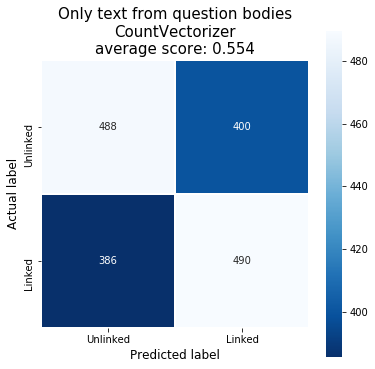

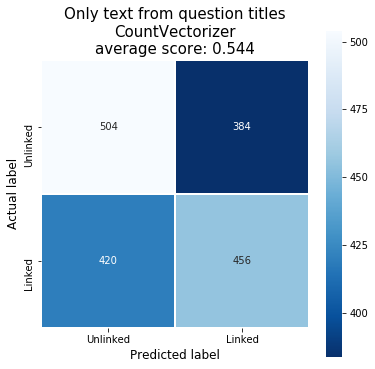

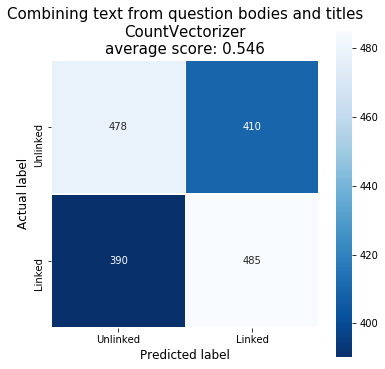

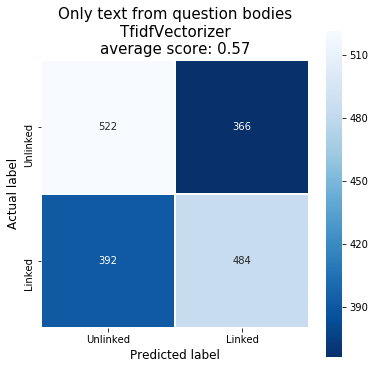

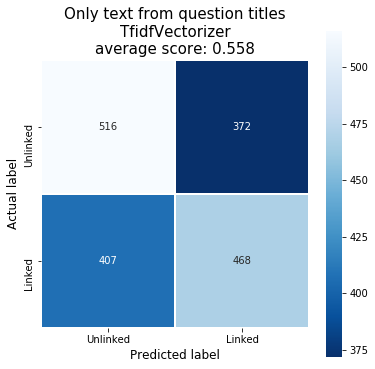

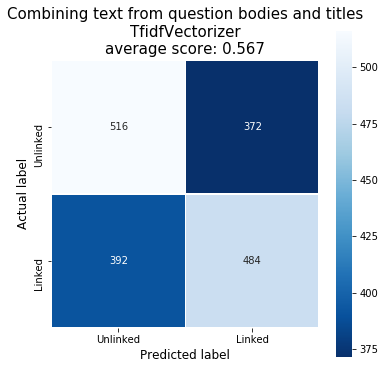

In [121]:
plot_average_confusion_matrix(count_body_scores,
                              count_body_confusion_matrices,
                              'Only text from question bodies\nCountVectorizer')
plot_average_confusion_matrix(count_title_scores,
                              count_title_confusion_matrices,
                              'Only text from question titles\nCountVectorizer')
plot_average_confusion_matrix(count_bt_scores,
                              count_bt_confusion_matrices,
                              'Combining text from question bodies and titles\nCountVectorizer')
plot_average_confusion_matrix(tfidf_body_scores,
                              tfidf_body_confusion_matrices,
                              'Only text from question bodies\nTfidfVectorizer')
plot_average_confusion_matrix(tfidf_title_scores,
                              tfidf_title_confusion_matrices,
                              'Only text from question titles\nTfidfVectorizer')
plot_average_confusion_matrix(tfidf_bt_scores,
                              tfidf_bt_confusion_matrices,
                              'Combining text from question bodies and titles\nTfidfVectorizer')

### Conclusions:

Taking text from the bodies and titles of a sample of approximately 7,000 questions did not yield a simple and successful model for predicting whether the question would be linked to a Knowledge Base Article (KBA).

Of the total vSphere 5.5 sample, approximately 5% of all questions ended up being linked to at least one KBA. This lead to the need for balancing the classes, reducing the initial sample of 70,000 questions to 7,052 with an equal split of linked and unlinked questions.

The models considered in this work used both the Count and TF-IDF vectorizers from the Python `sklearn` package. For both options, there were three models constructed, one that considered only the text in the bodies of the questions, one that considered only the titles of the questions and a last model that combined both. 

In all six instances, the `score` reported by the vectorizer was in the range of 55%. This score is the fraction of all questions in the test sample that were correctly predicted. Whie slightly more questions were correctly predicted than not, the correctly predicted questions were fairly evenly split between those that are linked and those are not. Similarly, the incorrectly predicted questions were evenly split. The fact that both the correct and incorrect predictions were evenly distributed between the classes is because it is a binary choice for a balanced sample.

These tests have been performed with and without removing English stop words during the vectorization process. Doing so had little difference on the outcome (to the level of $\Delta score = 1 \times 10^{-3}$).